In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import lightgbm as lgb

In [2]:
train = pickle.load( open( "../input/ff-partition/train", "rb" ) )
dev = pickle.load( open( "../input/ff-partition/dev", "rb" ) )
print(train.shape)
dev.shape

(269118, 13)


(67280, 13)

In [3]:
X = train.drop(['success','split'], axis = 1)
y = train['success']
X_dev = dev.drop(['success','split'], axis = 1)
y_dev = dev['success']

In [4]:
X_test = dev.drop(['success','split'], axis = 1)
y_test = dev['success']

**Grid Search**

Accuracy of the GBM on dev set: 0.926
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     54212
           1       0.79      0.85      0.82     13068

    accuracy                           0.93     67280
   macro avg       0.88      0.90      0.89     67280
weighted avg       0.93      0.93      0.93     67280



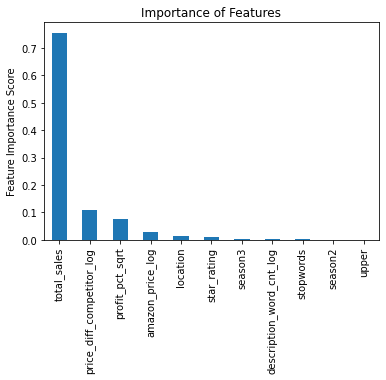

In [6]:
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X,y)
predictors=list(X)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on dev set: {:.3f}'.format(baseline.score(X_dev, y_dev)))
pred=baseline.predict(X_dev)
print(classification_report(y_dev, pred))

**Tuning learning rate and n_estimators**

In [8]:
p_test3 = {'learning_rate':[0.25,0.2,0.15,0.1,0.05,0.01], 'n_estimators' : [int(x) for x in np.linspace(start = 300, stop = 1000, num = 7)]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=3)
tuning.fit(X,y)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'n_estimators': 883}, 0.9290980164834757)

**Tuning Max Depth**

In [9]:
p_test2 = {'max_depth':[int(x) for x in np.linspace(2, 10, num = 8)] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15,n_estimators=900, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4, cv=3,verbose=2)
tuning.fit(X,y)
tuning.best_estimator_, tuning.best_params_, tuning.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 26.3min finished


[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total= 1.6min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total= 2.2min
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total= 2.8min
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total= 4.1min
[CV] max_depth=7 .....................................................
[CV] ...................................... max_depth=7, total= 4.9min
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total= 6.1min


(GradientBoostingClassifier(learning_rate=0.15, max_features='sqrt',
                            n_estimators=900, random_state=10, subsample=1),
 {'max_depth': 3},
 0.9291091640098396)

Accuracy of the GBM on dev set: 0.929
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     54212
           1       0.80      0.85      0.82     13068

    accuracy                           0.93     67280
   macro avg       0.88      0.90      0.89     67280
weighted avg       0.93      0.93      0.93     67280



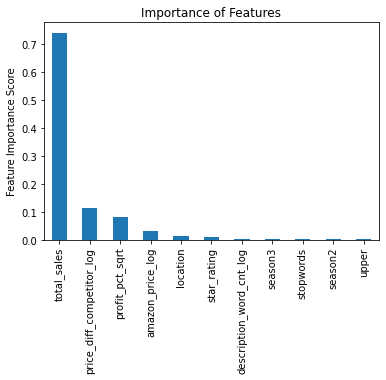

In [10]:
model1 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X,y)
predictors=list(X)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on dev set: {:.3f}'.format(model1.score(X_dev, y_dev)))
pred=model1.predict(X_dev)
print(classification_report(y_dev, pred))

**Tuning min_samples_split, min_samples_leaf**

In [5]:
p_test4 = {'min_samples_split':[int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)],
           'min_samples_leaf':[77,99,111,155,221]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
tuning.fit(X,y)
tuning.best_estimator_, tuning.best_params_, tuning.best_score_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 27.1min finished


(GradientBoostingClassifier(learning_rate=0.2, max_features='sqrt',
                            min_samples_leaf=111, min_samples_split=2000,
                            n_estimators=600, random_state=10, subsample=1),
 {'min_samples_leaf': 111, 'min_samples_split': 2000},
 0.9288379075349846)

**Tuning max features**

In [6]:
p_test5 = {'max_features':[3,4,5,6,7,9]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3,
                                                            min_samples_split=2000, min_samples_leaf=111, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
tuning.fit(X,y)
tuning.best_estimator_, tuning.best_params_, tuning.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 10.1min finished


(GradientBoostingClassifier(learning_rate=0.2, max_features=3,
                            min_samples_leaf=111, min_samples_split=2000,
                            n_estimators=600, random_state=10, subsample=1),
 {'max_features': 3},
 0.9288379075349846)

**Tuning subsample**

In [8]:
p_test6= {'subsample':[0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15, n_estimators=900, max_depth=3,
                    min_samples_split=2000, min_samples_leaf=111, max_features=3 , random_state=10),
                    param_grid = p_test6, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
tuning.fit(X,y)
tuning.best_estimator_,tuning.best_params_, tuning.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  8.4min finished


(GradientBoostingClassifier(learning_rate=0.15, max_features=3,
                            min_samples_leaf=111, min_samples_split=2000,
                            n_estimators=900, random_state=10, subsample=1),
 {'subsample': 1},
 0.9288193283243782)

# **Evaluation of final model on Dev set**

Accuracy of the GBM on dev set: 0.928
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     54212
           1       0.79      0.85      0.82     13068

    accuracy                           0.93     67280
   macro avg       0.88      0.90      0.89     67280
weighted avg       0.93      0.93      0.93     67280



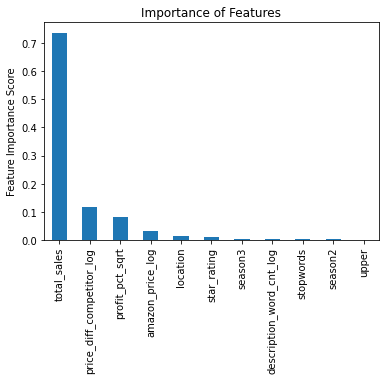

In [9]:
new=GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3,
                               min_samples_split=2000, min_samples_leaf=111, max_features=3, subsample=1,
                               random_state=10)
new.fit(X,y)
predictors=list(X)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on dev set: {:.3f}'.format(new.score(X_dev, y_dev)))
pred=new.predict(X_dev)
print(classification_report(y_dev, pred))

One of the models that showed slightly better results was p_test2. I'll run it again with the parameters gathered so far.

In [10]:
p_test2=GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3,
                               min_samples_split=2, min_samples_leaf=1, max_features=3, subsample=1,
                               random_state=10)
p_test2.fit(X,y)

print('Accuracy of the GBM on dev set: {:.3f}'.format(p_test2.score(X_dev, y_dev)))
pred=p_test2.predict(X_dev)
print(classification_report(y_dev, pred))

Accuracy of the GBM on dev set: 0.929
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     54212
           1       0.80      0.85      0.82     13068

    accuracy                           0.93     67280
   macro avg       0.88      0.90      0.89     67280
weighted avg       0.93      0.93      0.93     67280



Baseline model shows accuracy of 0.926

Hypertuned model increased accuracy to 0.928

p_test2 model increased accuracy to 0.929 - THE BEST RESULTS


# Final Model Test

In [5]:
mod = GradientBoostingClassifier(learning_rate=0.15, n_estimators=900,max_depth=3,
                               min_samples_split=2, min_samples_leaf=1, max_features=3, subsample=1,
                               random_state=10)
mod.fit(X,y)

GradientBoostingClassifier(learning_rate=0.15, max_features=3, n_estimators=900,
                           random_state=10, subsample=1)

In [15]:
pred = mod.predict(X_test)
print(metrics.accuracy_score(y_test,pred))
print(classification_report(y_test, pred))

0.9285374554102259
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     54212
           1       0.80      0.85      0.82     13068

    accuracy                           0.93     67280
   macro avg       0.88      0.90      0.89     67280
weighted avg       0.93      0.93      0.93     67280



In [12]:
print(['Final result of the model on the terst set are : Accuracy:',metrics.accuracy_score(y_test,pred)])

['Final result of the model on the terst set are : Accuracy:', 0.9285374554102259]


#########################